# Waveform Plots

Here we plot waveforms as seen from the oscilloscope while we were collecting data.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import csvlib
import pandas as pd
from tqdm import tqdm

/Users/panos/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# First we pick a data set using a folder name
directory = 'AC_VERDET_ROD'     # Directory of the data
angle_correction = 343.81
angle_c          = angle_correction/180*np.pi
pol_angle        = 3.896113 # degrees
pol_angle_rad    = pol_angle/180*np.pi

# Now define some parameters for the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 1,              # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 1,              # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 1,              # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 1e-2,           # Material length in the solenoid in m
    'Sigma_L'      : 1e-3,           # Uncertainty in Length
}

# print the setup file for this directory
def print_setup(directory=directory):
    file = open(directory+'/Setup.txt')
    lines = file.readlines()
    file.close
    
    for line in lines:
        print(line,end='')

# Returns a data frame for the measurements of that particular angle
def get_angle(angle,directory=directory):
    angle = int(angle)
    data = pd.read_csv(directory+'/Angle-%d.csv'%angle)

    return data.to_numpy().T

# Get the raw data for voltage and amplitude
def get_voltage_vs_amplitude(directory=directory):
    data = pd.read_csv(directory+'/Voltage-Amplitude.csv'%angle)
    return data.to_numpy().T

# Returns average and standard deviation
def get_stats(data):
    return np.mean(data), np.std(data)

# Returns a calculated data set with mean and stds for a set of angles
def voltage_vs_angle(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=5):
    V = []
    V_std = []
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        mean,std = get_stats(data[channel])

        V.append(mean)
        V_std.append(std)

    return np.array(V),np.array(V_std),angles

# get the raw data for the current among a list of angles
def get_current_ac(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=1):
    time  = np.array(get_angle(0)[0])
    I     = np.zeros(time.shape)
    I_std = np.zeros(time.shape)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I += data[channel]
    
    I = np.array(I)/len(angles)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I_std += (np.array(data[channel]) - I)**2
    
    I_std /= len(angles)
    
    return I, I_std**0.5, time


# Plot a voltage VS amplitude graph
def plot_VA(angles=np.linspace(0,360,360,dtype=int),V=None,V_std=None,directory=directory,channel=5,\
            title='Lock-in Output VS Angle',average=0.97):

    if type(V) == type(None) or type(V_std) == type(None):
        V,V_std,_ = voltage_vs_angle(directory=directory,channel=channel)

    # Create the figure
    fig = plt.figure(figsize=(15,5),dpi=300)
    ax = fig.add_subplot(111)
    
    # Plot
    ax.errorbar(angles/180,V,yerr=V_std,color='deepskyblue',fmt='.',ms=2,label='Raw Data')
    
    # Make the figure look pretty
    ax.set_xlim(min(angles)/180, max(angles)/180)
    ax.set_ylim(min(V)*1.1,max(V)*1.1)
    grid_x_major = np.arange(min(angles)/180, max(angles)/180, 0.25)
    grid_x_minor = np.arange(min(angles)/180, max(angles)/180, 0.25/5)

    ax.set_title(title)
    ax.set_xlabel(r'Polariser Angle $\theta$ [rad]')
    ax.set_ylabel(r'Lock-in output V [V]')
    
    ax.set_xticks(grid_x_major)
    ax.set_xticks(grid_x_minor,minor=True)
    ax.xaxis.grid(True, which='both')
    ax.grid(which='minor', alpha=0.4, linestyle='--')
    ax.tick_params(axis="both",which="both", direction="in")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    
    ax.fill_between(angles/180, 2*min(V), 2*max(V), where=(abs(V) > max(V)*average), color='deepskyblue',alpha=0.5,\
                    label='Maximum Oscillation Areas')

    ax.legend(frameon = False)
    
    return fig,ax

# Plot the lock in at a particular angle
def plot_lock_in(angle,directory=directory,channel=3):
    data    = get_angle(angle,directory=directory)
    time    = data[2*(channel-1)]
    lock_in = data[2*(channel-1)+1]

    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    ax.plot(time,lock_in,color='mediumseagreen')

    return fig,ax

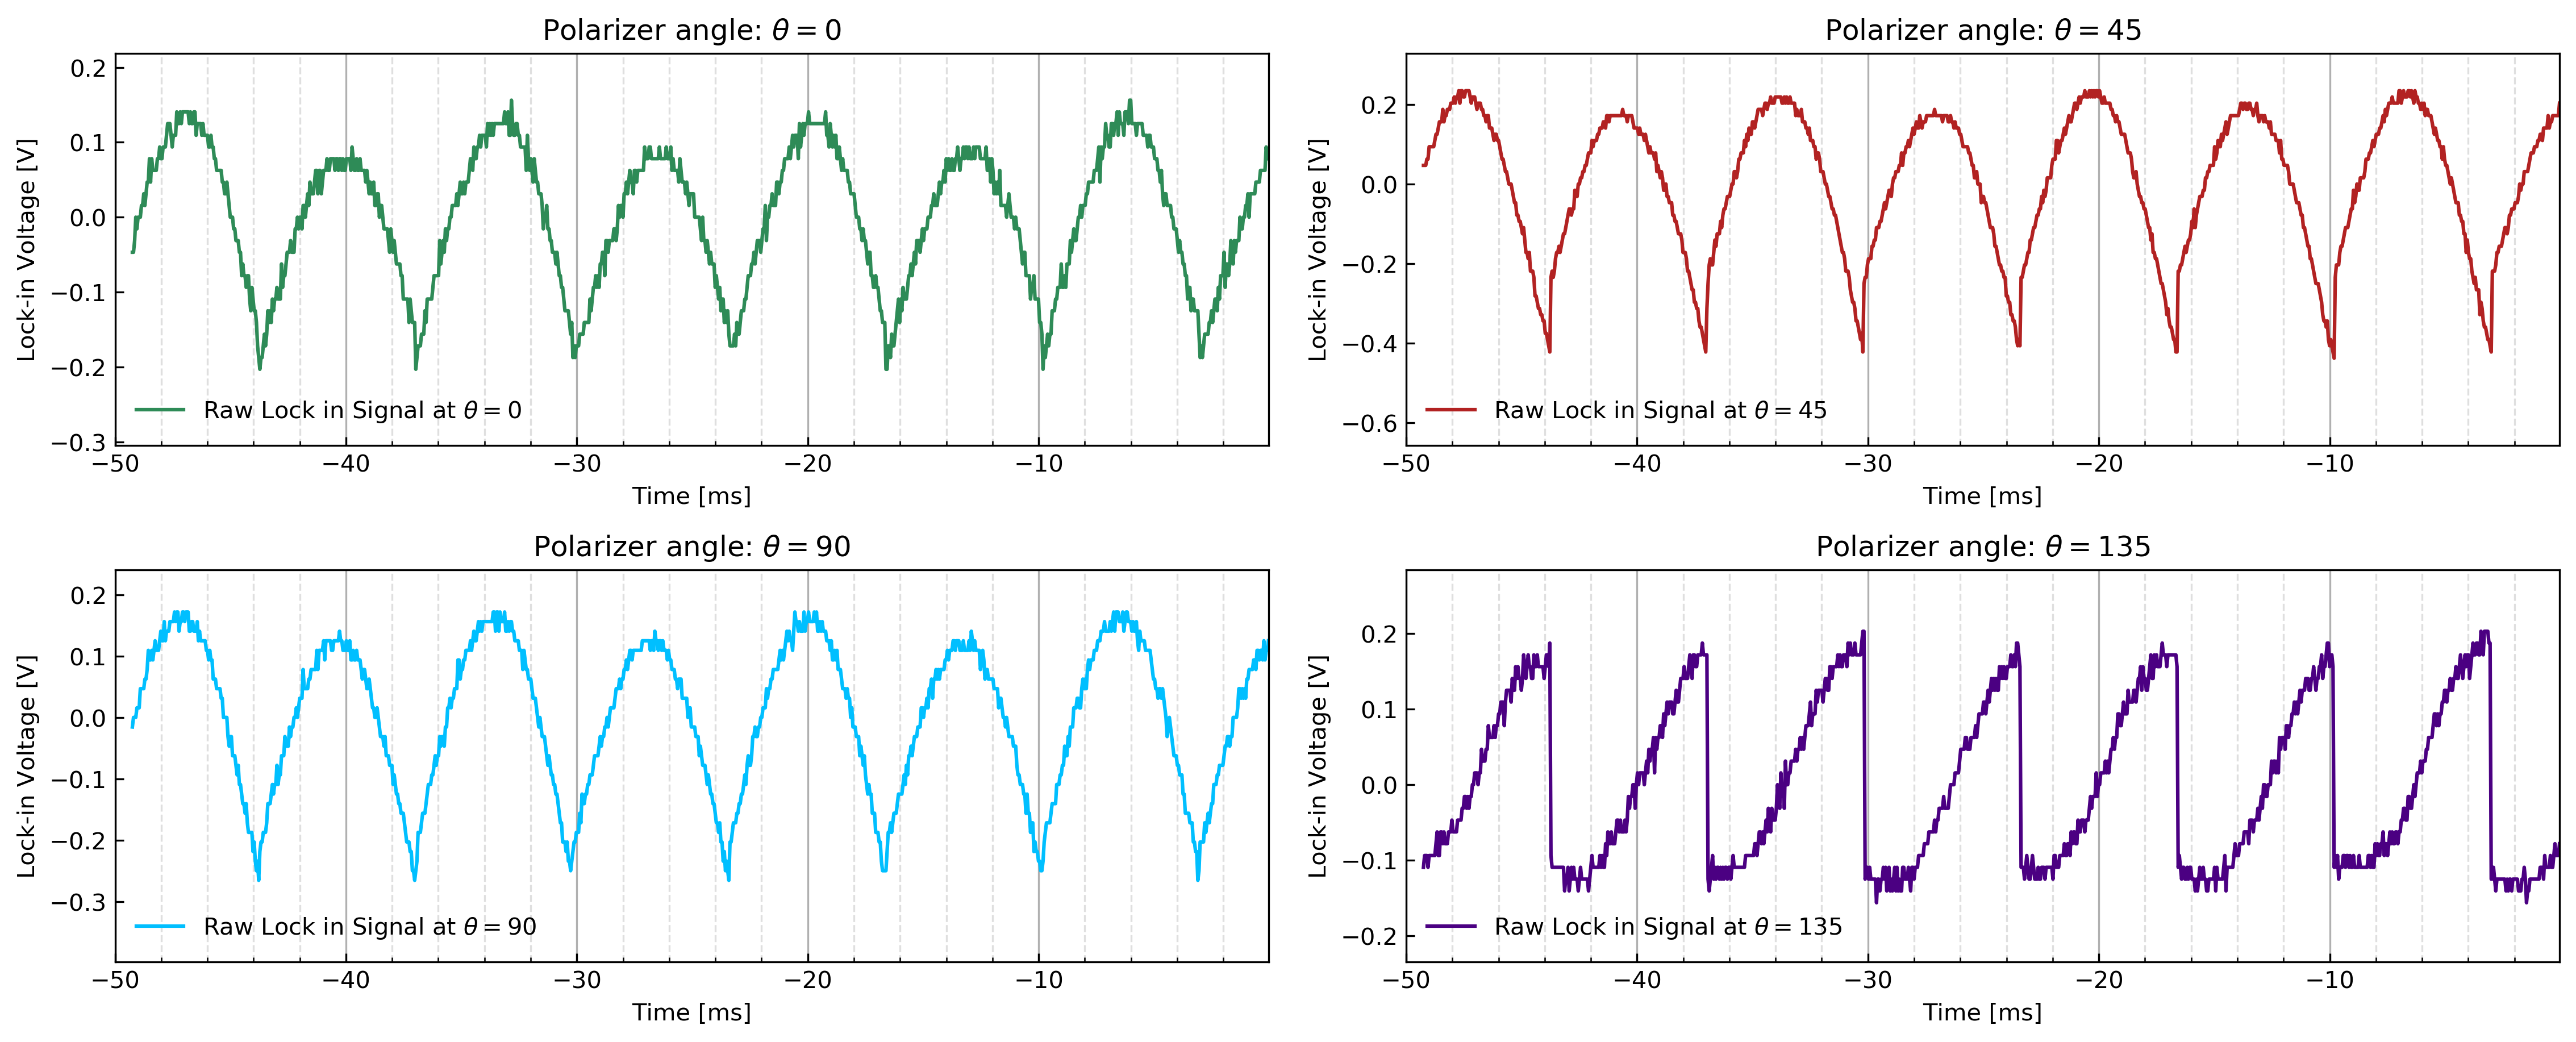

In [40]:
# Plot the lock in signal for various amplitudes
directory = 'AC_VERDET_ROD'
channel = 2

# Create figure
fig = plt.figure(figsize=(15,6),constrained_layout=True,dpi = 300)
gs  = fig.add_gridspec(2,2)

# Plot for the following polarizer angles
angles = [0,45,90,135]
dirs   = [(0,0),(0,1),(1,0),(1,1)]
colors = ['seagreen','firebrick','deepskyblue','indigo']

# Create the axes

# For each axis ##############
for i in range(len(angles)):
    # get the data
    angle   = angles[i]
    data    = get_angle(angle,directory=directory)
    time    = data[2*(channel-1)]
    lock_in = data[2*(channel-1)+1]

    # Create the axis and plot
    ax1 = fig.add_subplot(gs[dirs[i]])
    ax1.plot(time,lock_in,c=colors[i],label=r'Raw Lock in Signal at $\theta = %d$'%(angle))

    # Prettify
    ax1.set_xlim(min(time), max(time))
    ax1.set_ylim(min(lock_in)*1.5,max(lock_in)*1.4)
    grid_x_major = np.arange(min(time)-0.75,max(time), 10)
    grid_x_minor = np.arange(min(time)-0.75,max(time), 2)

    ax1.set_title(r'Polarizer angle: $\theta = %d$'%(angle))
    ax1.set_xlabel(r'Time [ms]')
    ax1.set_ylabel(r'Lock-in Voltage [V]')

    ax1.set_xticks(grid_x_major)
    ax1.set_xticks(grid_x_minor,minor=True)
    ax1.xaxis.grid(True, which='both')
    ax1.grid(which='minor', alpha=0.4, linestyle='--')
    ax1.tick_params(axis="both",which="both", direction="in")

    ax1.legend(frameon = False,loc='lower left')

